In [1]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

from torchinfo import summary

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json, os, glob, time

import utils
import utils.data, utils.ML, utils.models
from utils.models import number_of_parameters

In [15]:
preprocess_clean = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])

denorm = transforms.Compose([transforms.Normalize([0, 0, 0], [1/0.229, 1/0.224, 1/0.225]),
                           transforms.Normalize([-0.485, -0.456, -0.406], [1., 1., 1.])])

In [17]:
path_to_im_folder = "/Users/lucas/Documents/Data/ImageNet/ILSVRC2012_img_val/"
path_to_labels_txt = "/Users/lucas/Documents/Data/ImageNet/imagenet_2012_validation_label_idxs.txt"

imagenet_val_clean = utils.data.ImageNet(path_to_im_folder, path_to_labels_txt, preprocess_clean)
imagenet_val = utils.data.ImageNet(path_to_im_folder, path_to_labels_txt, preprocess)

batch_size = 32
val_dataloader_clean = torch.utils.data.DataLoader(imagenet_val_clean, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(imagenet_val, batch_size=batch_size)

classes = utils.data.get_ImageNet_classes()

Text(0.5, 1.0, 'Shetland sheepdog, Shetland sheep dog, Shetland')

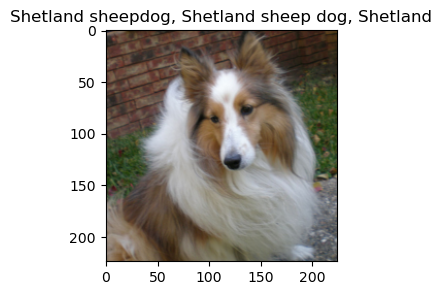

In [21]:
X, y = next(iter(val_dataloader_clean))

i = 2
im = X[i]
label = classes[y[i]]

plt.figure(figsize=(3, 3))
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title(label)

In [6]:
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

preprocessing = models.AlexNet_Weights.IMAGENET1K_V1.transforms()

In [4]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
summary(alexnet, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 1000]                --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 55, 55]          23,296
│    └─ReLU: 2-2                         [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 192, 27, 27]         307,392
│    └─ReLU: 2-5                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 384, 13, 13]         663,936
│    └─ReLU: 2-8                         [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 256, 13, 13]         884,992
│    └─ReLU: 2-10                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [32, 256, 13, 13]        

# Plot convolution filters:

In [39]:
for param in alexnet.named_parameters():
    print(param[0], param[1].shape)

features.0.weight torch.Size([64, 3, 11, 11])
features.0.bias torch.Size([64])
features.3.weight torch.Size([192, 64, 5, 5])
features.3.bias torch.Size([192])
features.6.weight torch.Size([384, 192, 3, 3])
features.6.bias torch.Size([384])
features.8.weight torch.Size([256, 384, 3, 3])
features.8.bias torch.Size([256])
features.10.weight torch.Size([256, 256, 3, 3])
features.10.bias torch.Size([256])
classifier.1.weight torch.Size([4096, 9216])
classifier.1.bias torch.Size([4096])
classifier.4.weight torch.Size([4096, 4096])
classifier.4.bias torch.Size([4096])
classifier.6.weight torch.Size([1000, 4096])
classifier.6.bias torch.Size([1000])


In [40]:
conv1 = alexnet.features[0].weight  # 11x11 filters
conv2 = alexnet.features[3].weight  # 5x5 filters
conv3 = alexnet.features[6].weight  # 3x3 filters
conv4 = alexnet.features[8].weight  # 3x3 filters
conv5 = alexnet.features[10].weight  # 3x3 filters

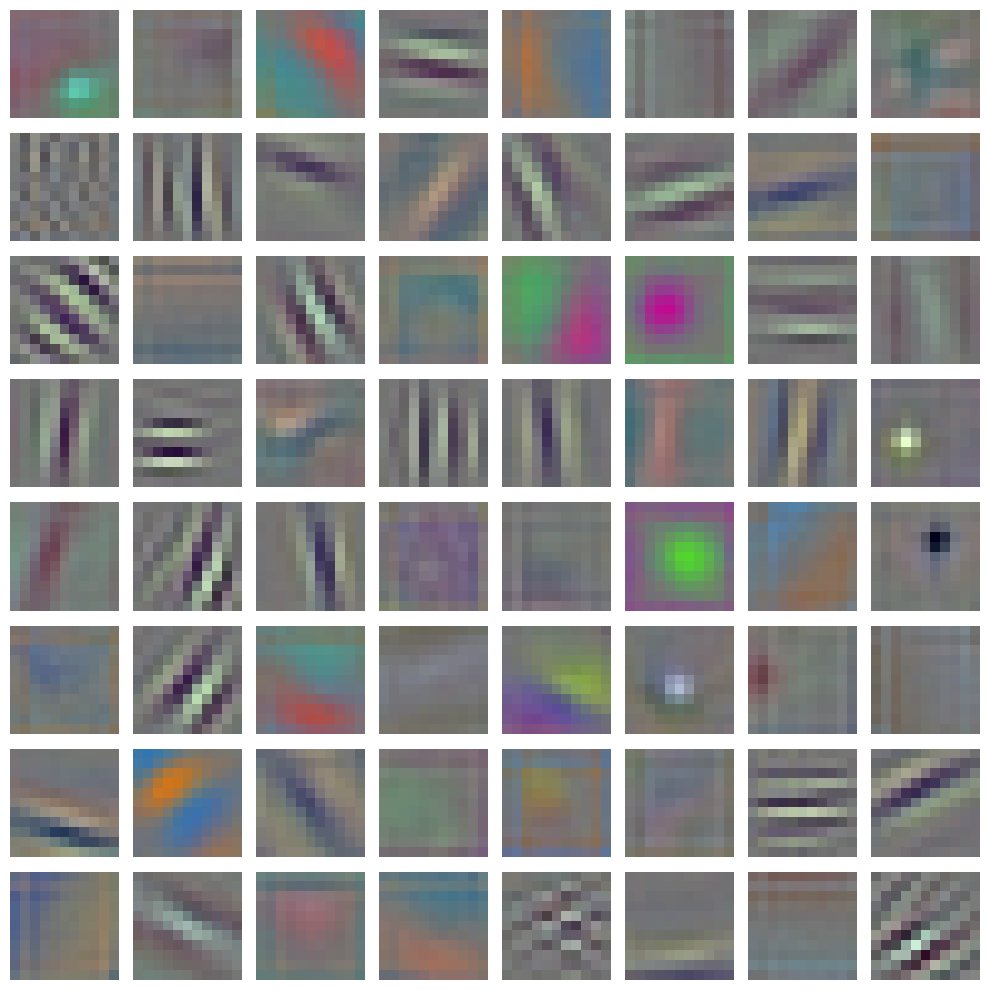

In [63]:
fig, axes = plt.subplots(8,8, sharex=True, sharey=True, figsize=(10,10))

min_, max_ = conv1.min(), conv1.max()

for i, ax in enumerate(axes.ravel()):
    kernel = conv1[i]
        
#     min_, max_ = kernel.min(), kernel.max()
    kernel_norm = ((kernel-min_)/(max_-min_)).detach().numpy()
    
    ax.imshow(np.transpose(kernel_norm, (1, 2, 0)))
    
    ax.axis('off')
    
fig.tight_layout()

In [79]:
print(conv2.shape)

energy = torch.sum(conv2**2, dim=(2, 3))

top_filter_idx = torch.argsort(energy.ravel(), descending=True)

torch.Size([192, 64, 5, 5])


In [80]:
top_filter_idx.shape

torch.Size([12288])

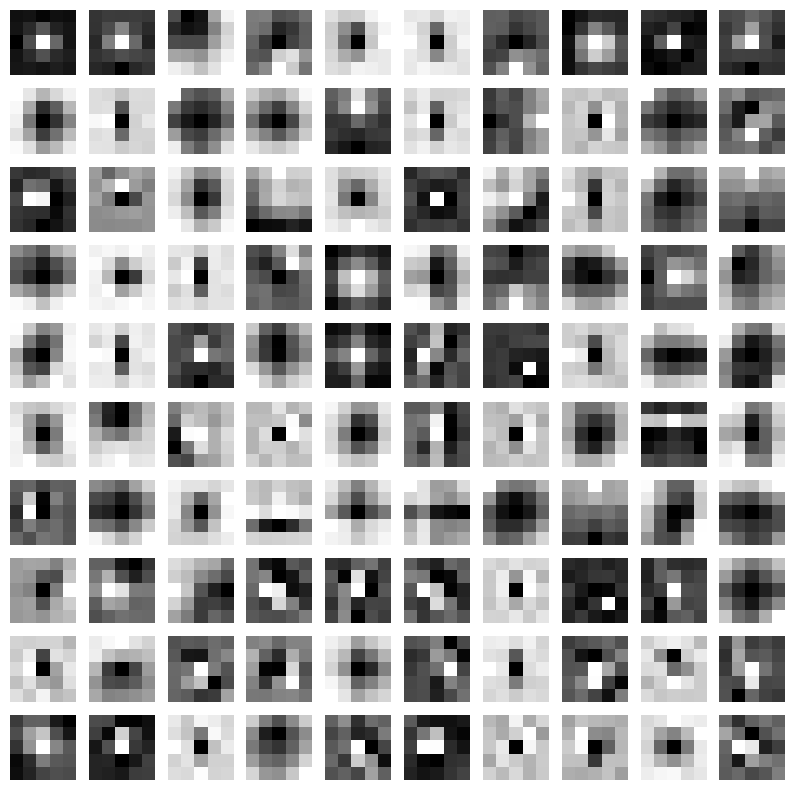

In [87]:
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,10))

min_, max_ = conv2.min(), conv2.max()

for i, ax in enumerate(axes.ravel()):

    idx_ravel = top_filter_idx[i]
#     print(idx_ravel, idx_ravel//64, idx_ravel%64, energy[idx_ravel//64, idx_ravel%64])
    kernel = conv2[idx_ravel//64, idx_ravel%64]
    
    kernel_norm = ((kernel-min_)/(max_-min_)).detach().numpy()
    
    ax.imshow(kernel_norm, cmap='gray')
    
    ax.axis('off')

# Visualize filter outputs:

In [112]:
X, y = next(iter(val_dataloader))
im_idx = 2

x = torch.unsqueeze(X[im_idx], 0)

In [123]:
outconv1 = alexnet.features[1](alexnet.features[0](x))
print(outconv1.shape)

torch.Size([1, 64, 55, 55])


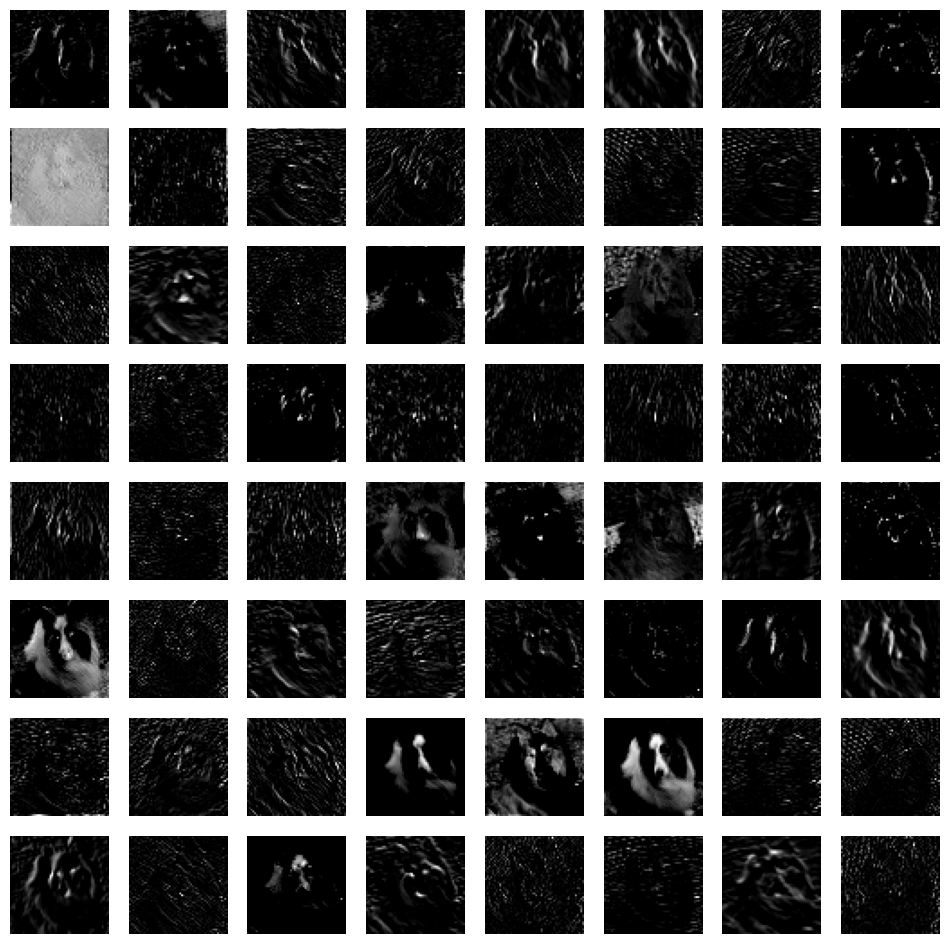

In [124]:
fig, axes = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(12,12))

for i, ax in enumerate(axes.ravel()):
    im = outconv1[0][i].detach().numpy()
    
    ax.imshow(im, cmap="gray")
    
    ax.axis('off')

In [128]:
# layer 2:

outconv2 = alexnet.features[4](alexnet.features[3](alexnet.features[2](outconv1)))
print(outconv2.shape)

torch.Size([1, 192, 27, 27])


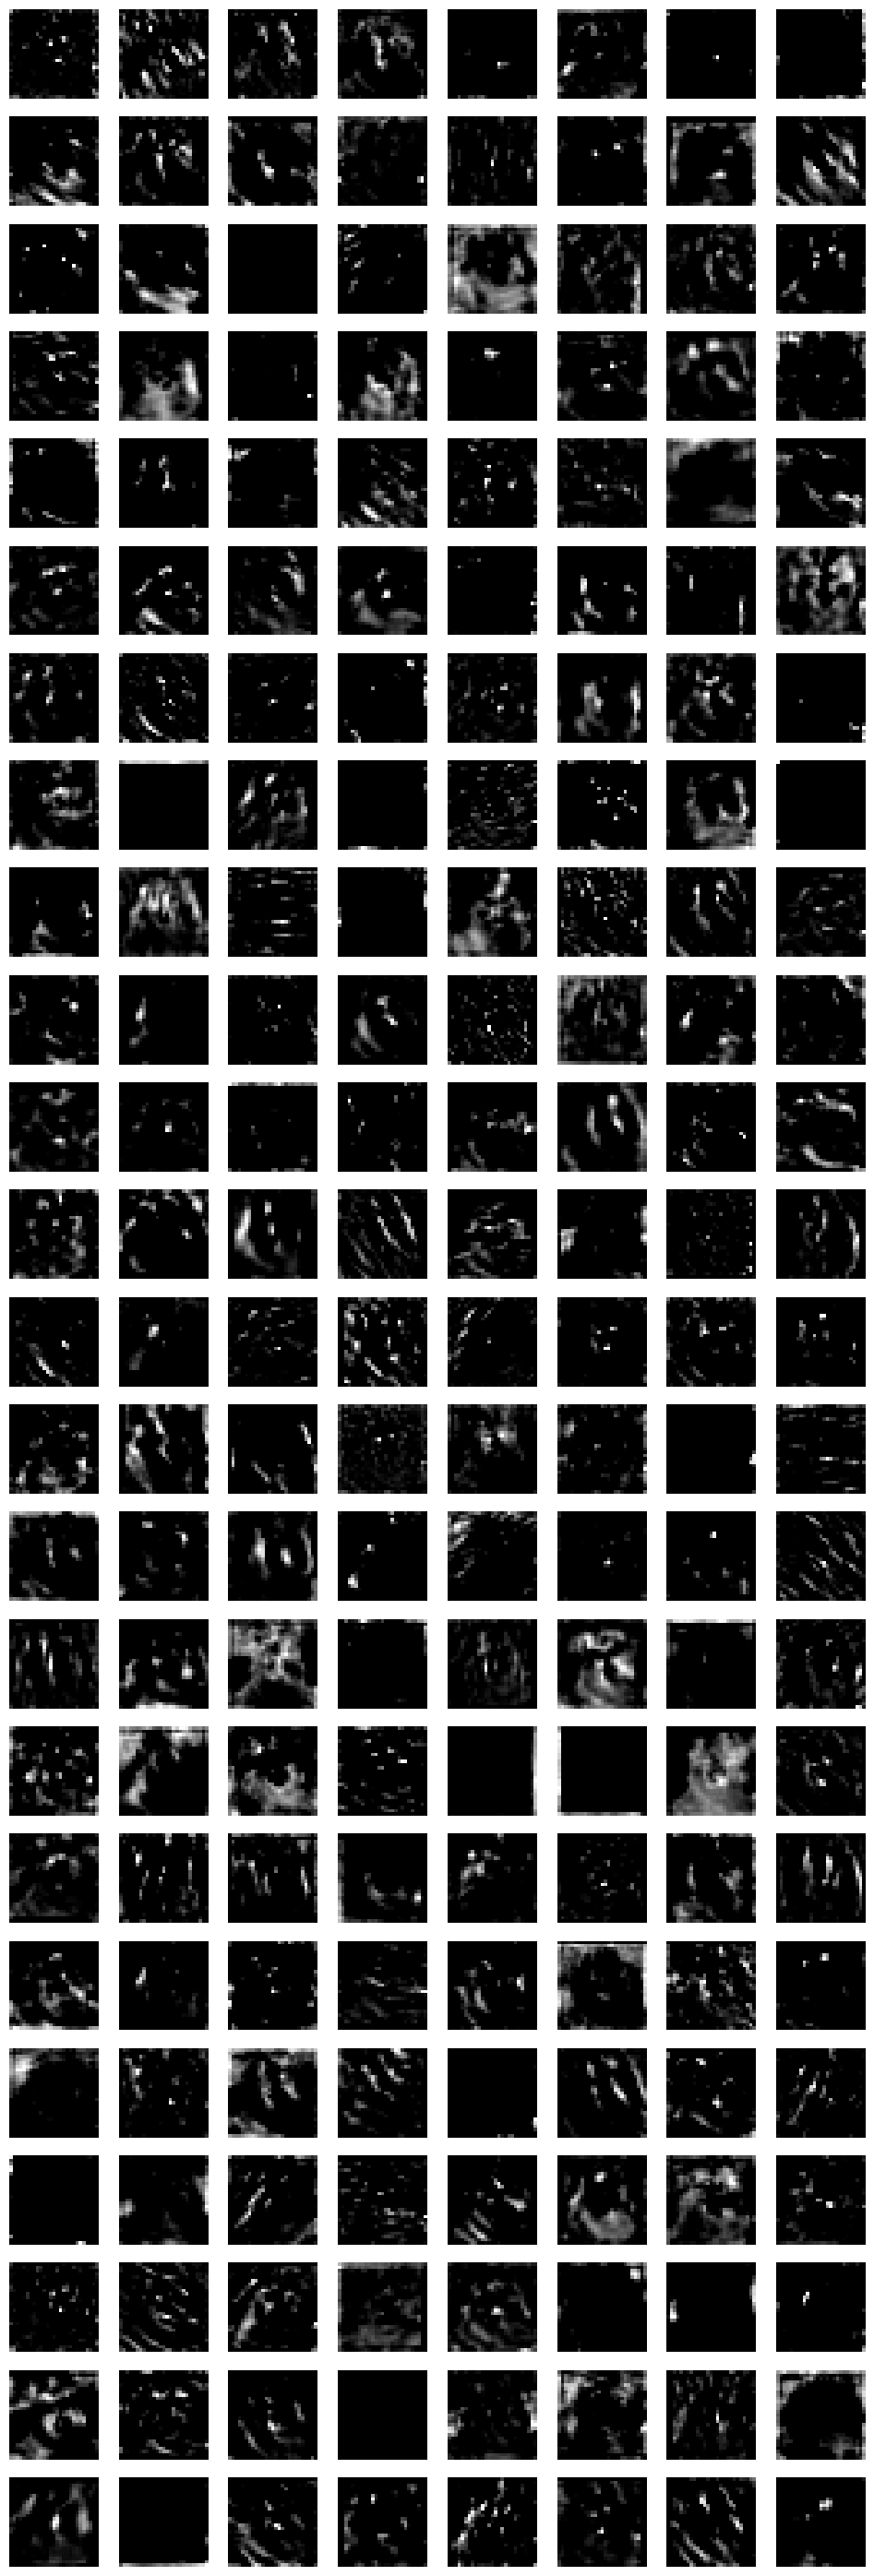

In [132]:
fig, axes = plt.subplots(24, 8, sharex=True, sharey=True, figsize=(12, 36))

for i, ax in enumerate(axes.ravel()):
    im = outconv2[0][i].detach().numpy()
    
    ax.imshow(im, cmap="gray")
    
    ax.axis('off')

In [133]:
# layer 3:

outconv3 = alexnet.features[7](alexnet.features[6](alexnet.features[5](outconv2)))
print(outconv3.shape)

torch.Size([1, 384, 13, 13])


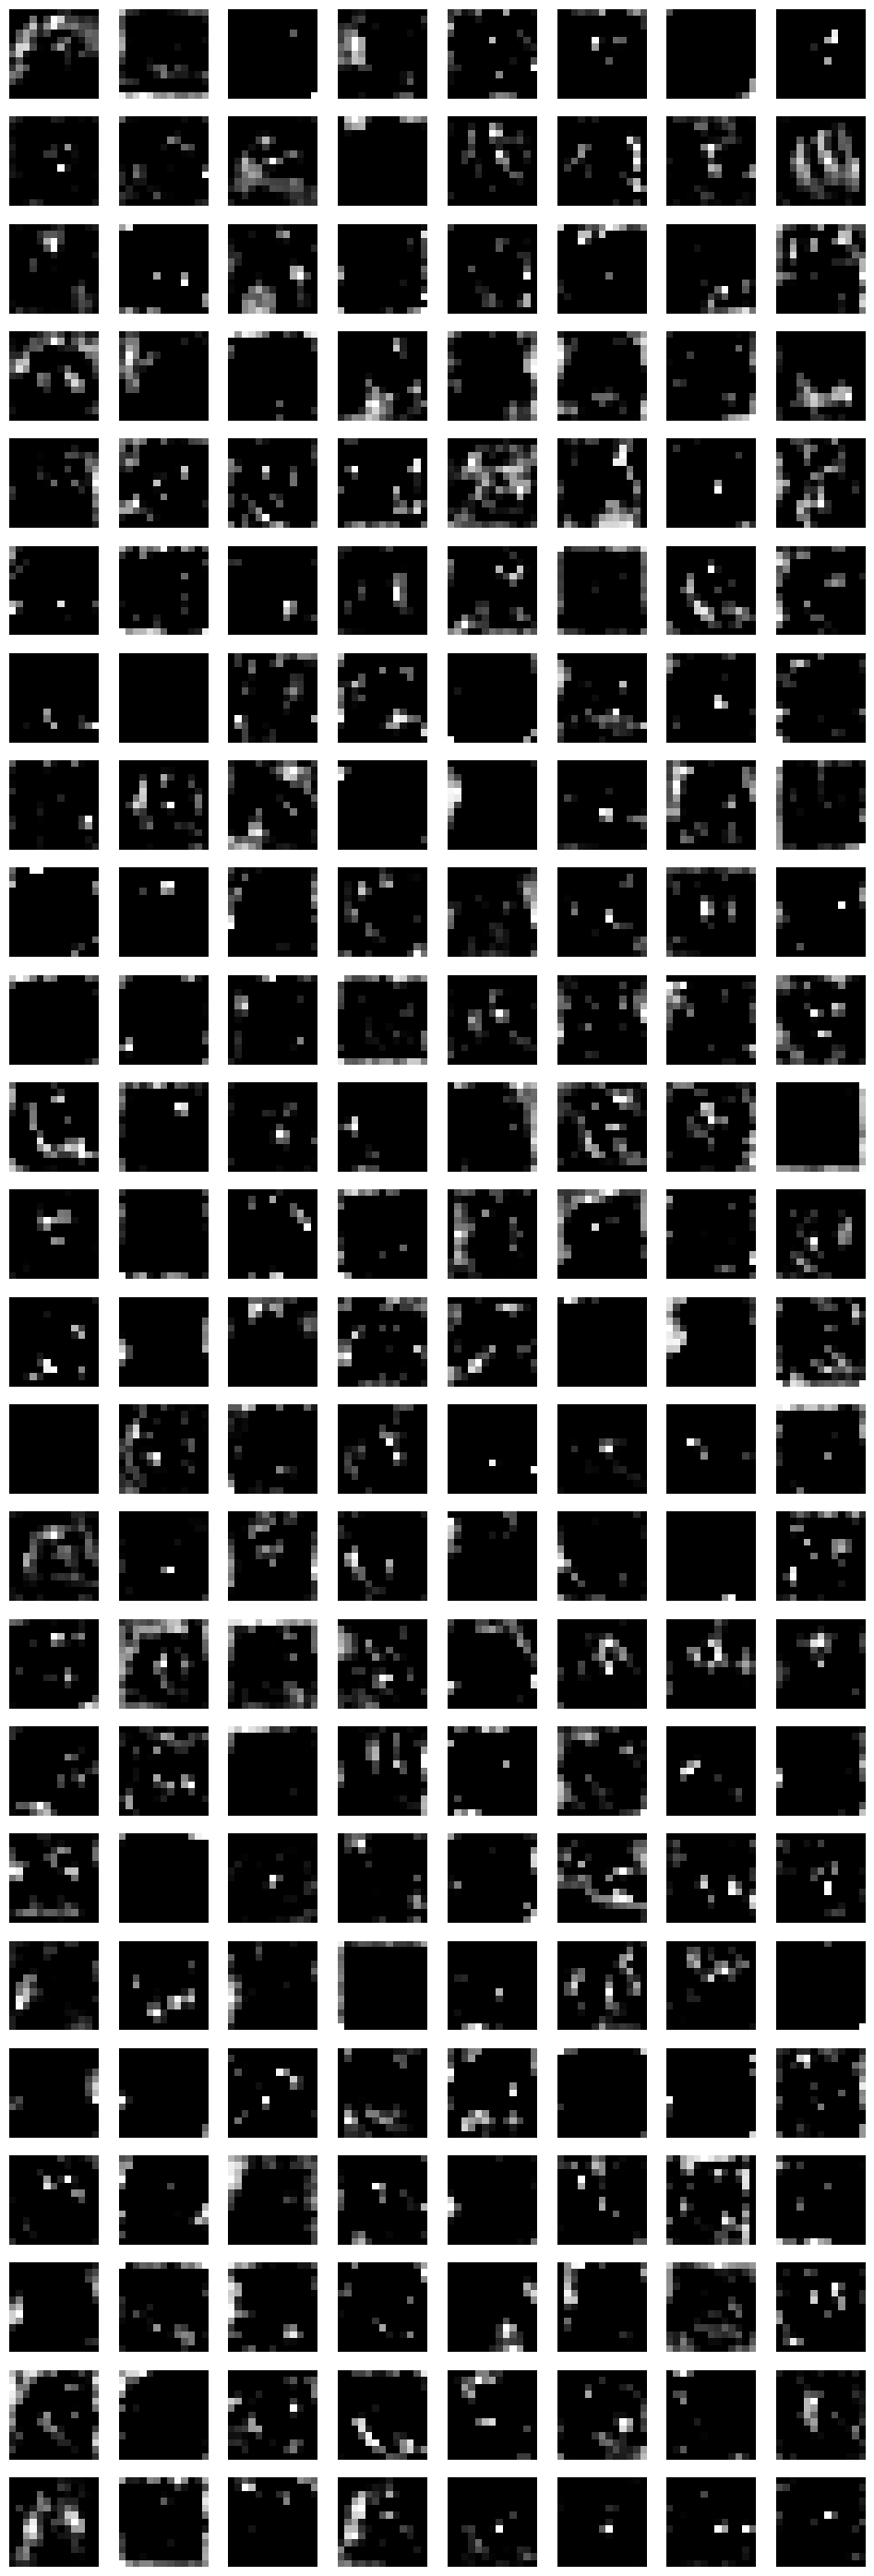

In [134]:
fig, axes = plt.subplots(24, 8, sharex=True, sharey=True, figsize=(12, 36))

for i, ax in enumerate(axes.ravel()):
    im = outconv3[0][i].detach().numpy()
    
    ax.imshow(im, cmap="gray")
    ax.axis('off')

In [137]:
# output of feature layer:

out_feature = alexnet.features(x)

print(out_feature.shape)

torch.Size([1, 256, 6, 6])


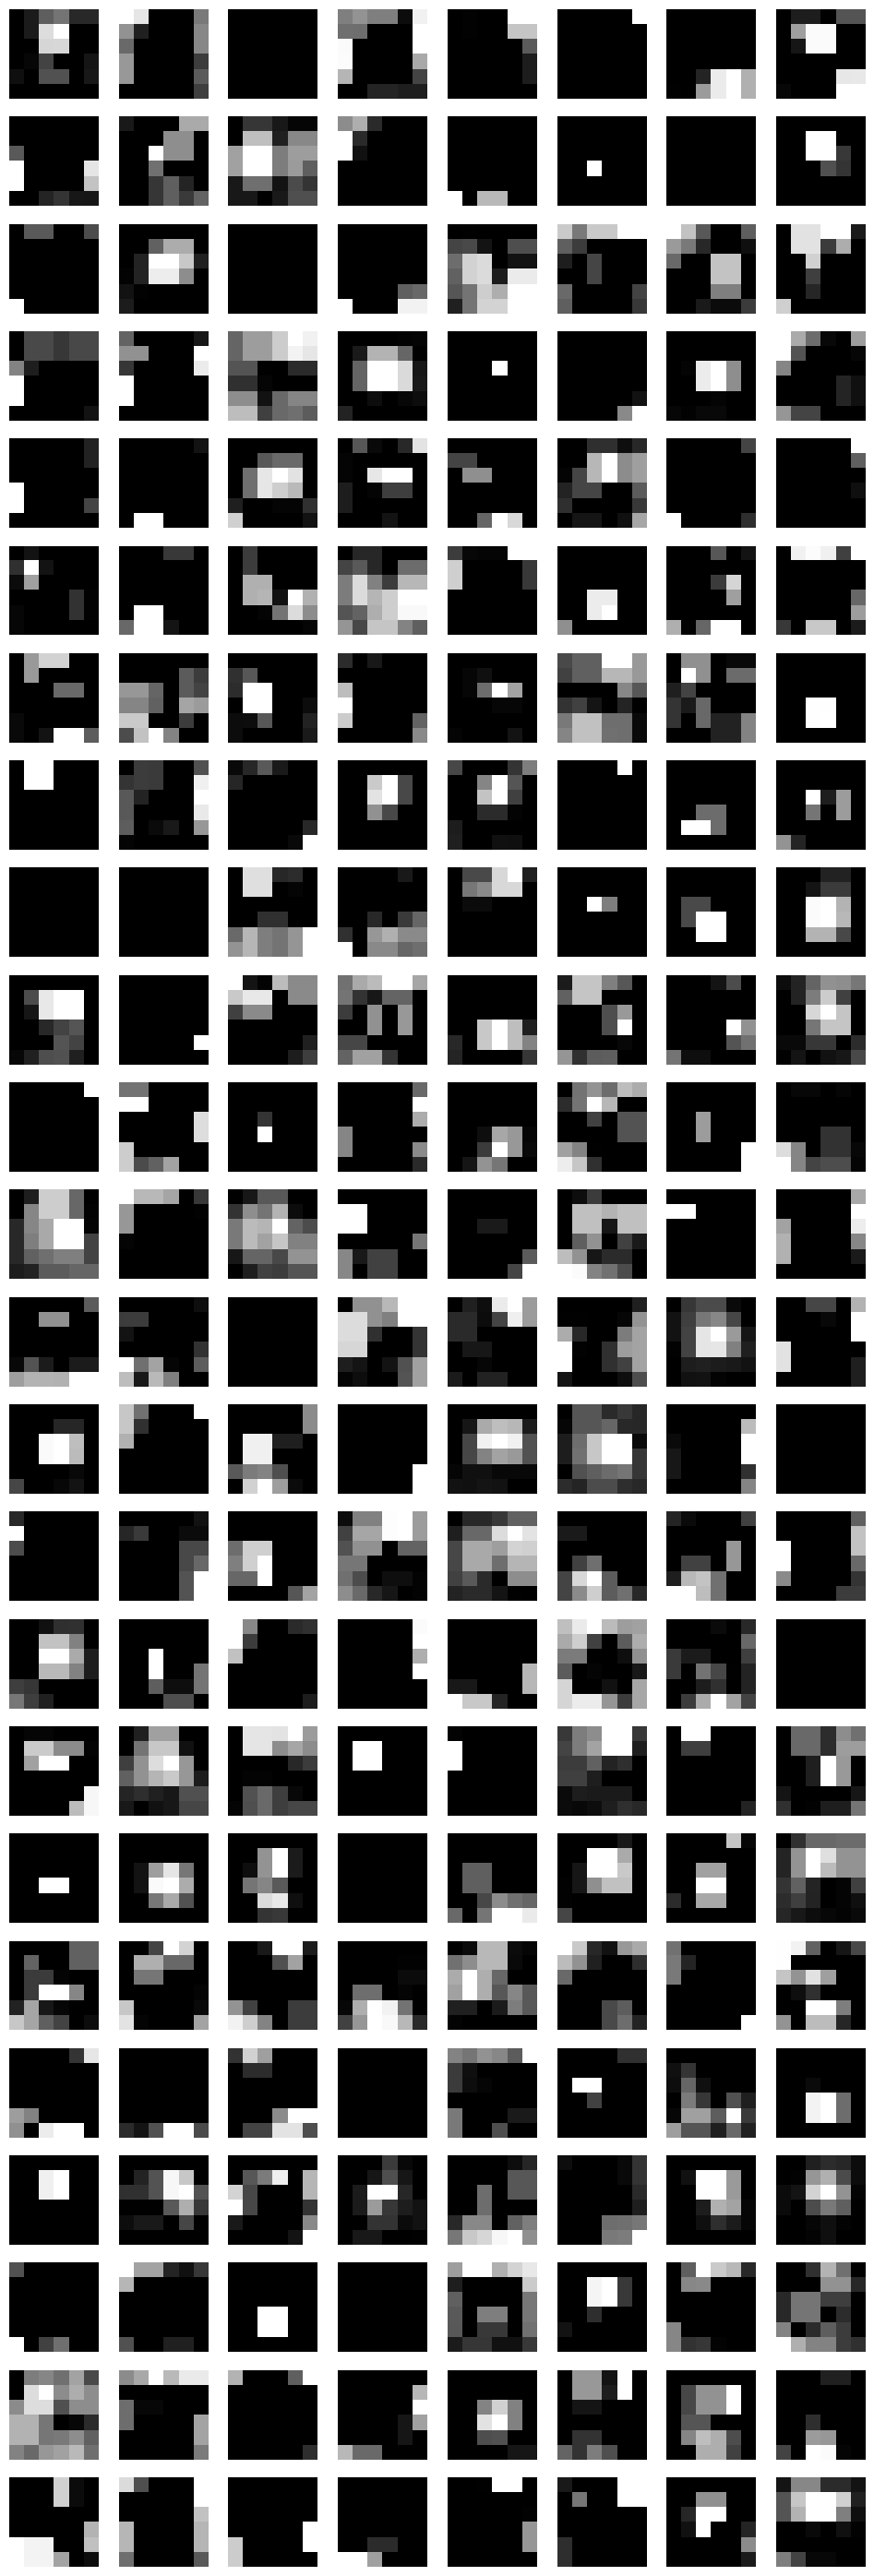

In [139]:
fig, axes = plt.subplots(24, 8, sharex=True, sharey=True, figsize=(12, 36))

for i, ax in enumerate(axes.ravel()):
    im = out_feature[0][i].detach().numpy()
    
    ax.imshow(im, cmap="gray")
    ax.axis('off')

# Activation maximization

In [175]:
for i, c in enumerate(classes):
    print(i, c)

0 tench, Tinca tinca
1 goldfish, Carassius auratus
2 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3 tiger shark, Galeocerdo cuvieri
4 hammerhead, hammerhead shark
5 electric ray, crampfish, numbfish, torpedo
6 stingray
7 cock
8 hen
9 ostrich, Struthio camelus
10 brambling, Fringilla montifringilla
11 goldfinch, Carduelis carduelis
12 house finch, linnet, Carpodacus mexicanus
13 junco, snowbird
14 indigo bunting, indigo finch, indigo bird, Passerina cyanea
15 robin, American robin, Turdus migratorius
16 bulbul
17 jay
18 magpie
19 chickadee
20 water ouzel, dipper
21 kite
22 bald eagle, American eagle, Haliaeetus leucocephalus
23 vulture
24 great grey owl, great gray owl, Strix nebulosa
25 European fire salamander, Salamandra salamandra
26 common newt, Triturus vulgaris
27 eft
28 spotted salamander, Ambystoma maculatum
29 axolotl, mud puppy, Ambystoma mexicanum
30 bullfrog, Rana catesbeiana
31 tree frog, tree-frog
32 tailed frog, bell toad, ribbed to

In [179]:
i_class = 84
print(classes[i_class])

peacock


In [234]:
def activation_maximization(class_idx, X_init = None, num_it = 100, lr = 1e-1):
    ''' Find input image that maximizes the output class'''
    
    if X_init is None:
        X = torch.randn(1, 3, 224, 224)
    else:
        X = X_init
    X.requires_grad = True

    for param in alexnet.parameters():
        param.requires_grad = False

    optimizer = torch.optim.Adam([X], lr=lr)

    loss_log = []

    def forward(X):
        logit = alexnet(X)
        out = logit[0, i_class]
        return out

    for it in range(num_it):

        out = forward(X)

        loss = -out

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #     print(f"it = {it}, loss = {loss:.3f}")
        loss_log.append(loss.item())
    
    return X

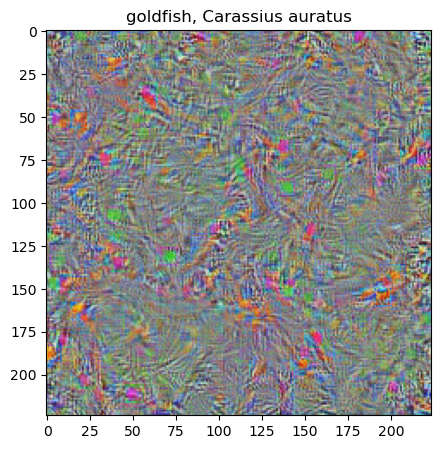

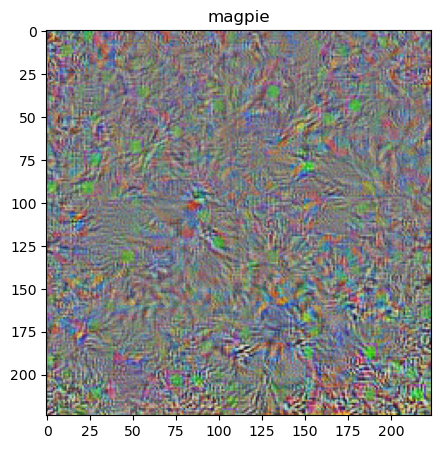

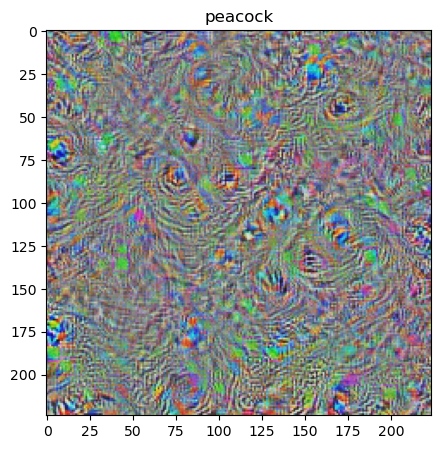

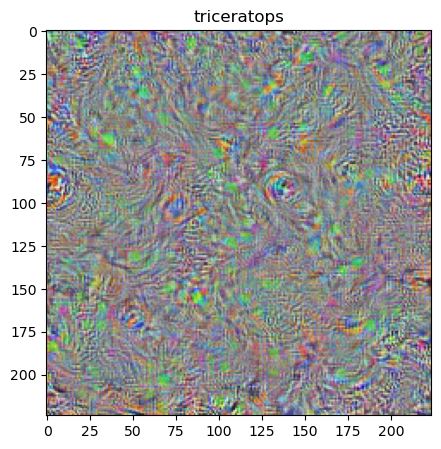

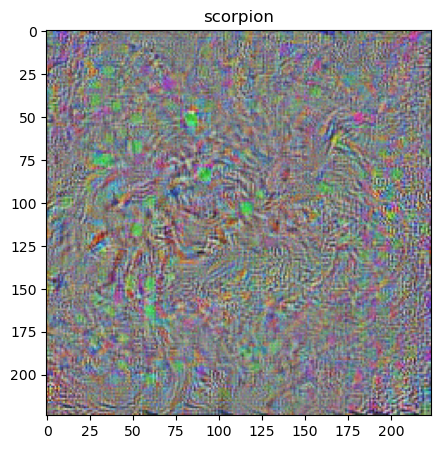

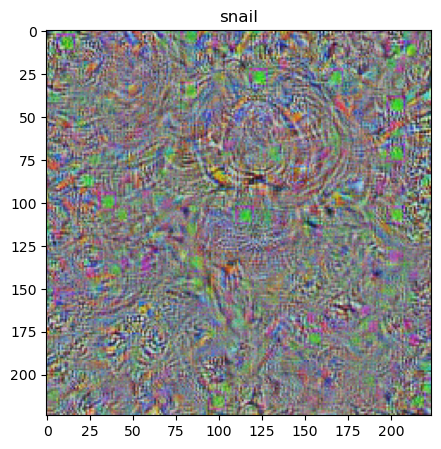

In [211]:
for i_class in [1, 18, 84, 51, 71, 113]:

    X = activation_maximization(i_class)
    
    X = X[0].detach().numpy()
    
    min_, max_ = X.min(), X.max()
    X_norm = (X-min_)/(max_-min_)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(np.transpose(X_norm, (1, 2, 0)))
    ax.set_title(classes[i_class])

# Adversarial examples:

In [237]:
# Load image:

X, y = next(iter(val_dataloader))

i = 2
x = torch.unsqueeze(X[i], 0)

softmax_fn = nn.Softmax(dim=-1)

prediction: Shetland sheepdog, Shetland sheep dog, Shetland, confidence: 80.17%


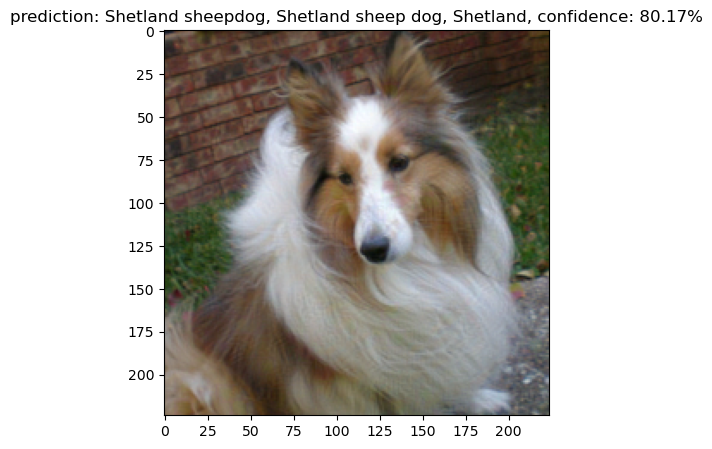

In [244]:
# prediction on original image:
out = alexnet(x)
softmax = softmax_fn(out)[0]
i_pred = torch.argmax(out)
# print(f"prediction: {classes[i_pred]}, confidence: {softmax[i_pred]*100:.2f}%")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.transpose(X_norm, (1, 2, 0)))
ax.set_title(f"prediction: {classes[i_pred]}, confidence: {softmax[i_pred]*100:.2f}%");

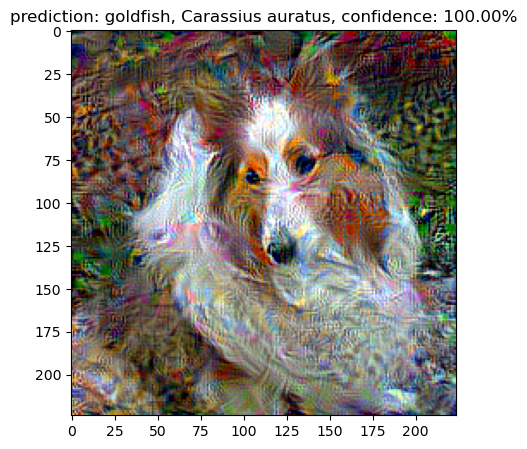

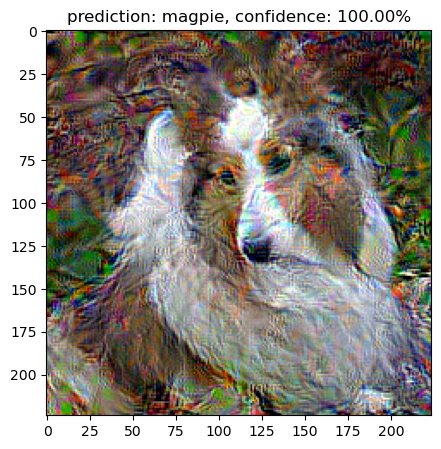

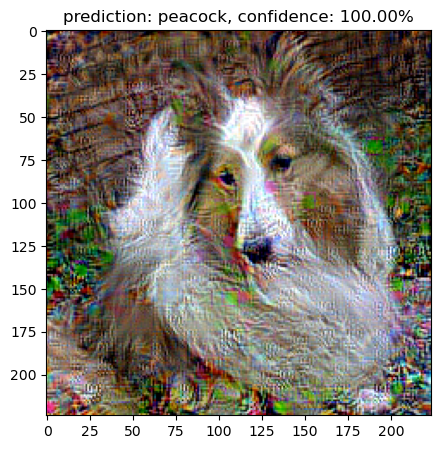

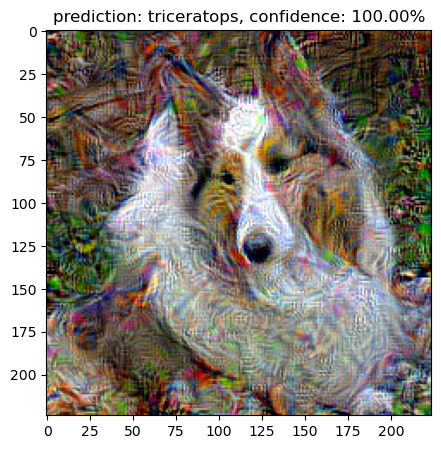

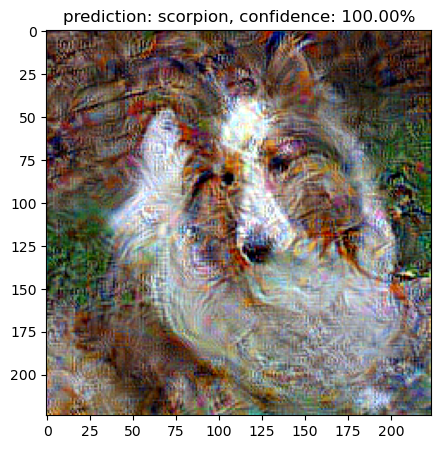

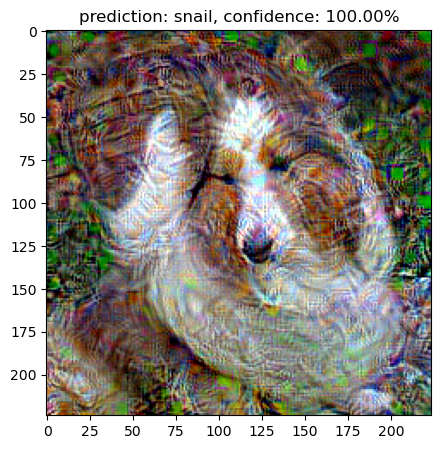

In [252]:
for i_class in [1, 18, 84, 51, 71, 113]:

    X = activation_maximization(i_class, X_init = x.clone().detach(), num_it=200, lr=1e-2)
    
    X_norm = denorm(X)[0].detach().numpy()
    X_norm = np.maximum(np.minimum(X_norm, 1.0), 0.0)
    
    # prediction:
    out = alexnet(X)
    softmax = softmax_fn(out)[0]
    i_pred = torch.argmax(out)
#     print(f"prediction: {classes[i_pred]}, confidence: {softmax[i_pred]*100:.2f}%")

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(np.transpose(X_norm, (1, 2, 0)))
    ax.set_title(f"prediction: {classes[i_pred]}, confidence: {softmax[i_pred]*100:.2f}%")